# Практика 1. Вариант 3. Иван Конюшенко

## №1. Метод Холецкого

### Разложение Холецкого

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ortho_group

from numpy.typing import NDArray, ArrayLike

In [3]:
def cholesky(A : NDArray, using_float16 : bool = False) -> NDArray:
    '''
    Takes positive-definite matrix A and returns its Cholesky decomposition matrix C, such that A = CC^T.
    '''
    CMP_CONST = 1e-8
    if using_float16:
        CMP_CONST = 1e-2

    if (abs(A - A.T) > CMP_CONST).any():
        raise ValueError('Given input matrix A is not symmetric.')
    with np.errstate(invalid='raise', under='ignore'):
        try:
            n = A.shape[0]
            if using_float16:
                C = np.zeros(shape=(n, n), dtype=np.float16)
            else:
                C = np.zeros(shape=(n, n))
            for j in range(0, n):
                C[j, j] = np.sqrt(A[j, j] - np.sum(C[j, :j] ** 2))

                for i in range(j + 1, n):
                    C[i, j] = A[i, j] - np.sum(C[i, :j] * C[j, :j])
                    C[i, j] /= C[j, j]
        except:
            raise ValueError('Given input matrix A is not positive-definite.')

    if (abs(A - C @ C.T) > CMP_CONST).any():
        raise ValueError('Given input matrix A is not positive-definite.')
    return C

#### Тестирование

In [4]:
np.random.seed(42)

##### Все работает

In [10]:
def make_good_matrix(size=10):
    eigenvals = np.random.randint(1, 5, size=size)
    K_true = eigenvals.max() / eigenvals.min()

    U = ortho_group.rvs(size)
    A = np.diag(eigenvals)
    return U.T @ A @ U, K_true

In [ ]:
A, _ = make_good_matrix(4)
A = np.float16(A)

In [ ]:
cholesky(A, True)

array([[ 1.467 ,  0.    ,  0.    ,  0.    ],
       [ 0.1588,  1.504 ,  0.    ,  0.    ],
       [-0.359 , -0.2347,  1.205 ,  0.    ],
       [ 0.307 ,  0.2152,  0.2947,  1.305 ]], dtype=float16)

##### Все ломается

In [ ]:
def make_bad_matrix(size=10):
    eigenvals = np.random.randint(-1000, -1, size=size)
    K_true = eigenvals.max() / eigenvals.min()

    U = ortho_group.rvs(size)
    A = np.diag(eigenvals)
    return U.T @ A @ U, K_true

In [ ]:
B, _ = make_bad_matrix(4)
cholesky(B)

ValueError: Given input matrix A is not positive-definite.

### Построение графиков

In [ ]:
np.random.seed(42)
sizes = [10, 100, 500, 1000, 2000]
norms = []

for size in sizes:
    with np.errstate(under='ignore'):
        A, _ = make_good_matrix(size)
        A = np.float16(A)
        C = cholesky(A, True)

        norm = np.sum((A - C @ C.T) ** 2) ** 0.5  # Frobenius norm
    norms.append(norm)

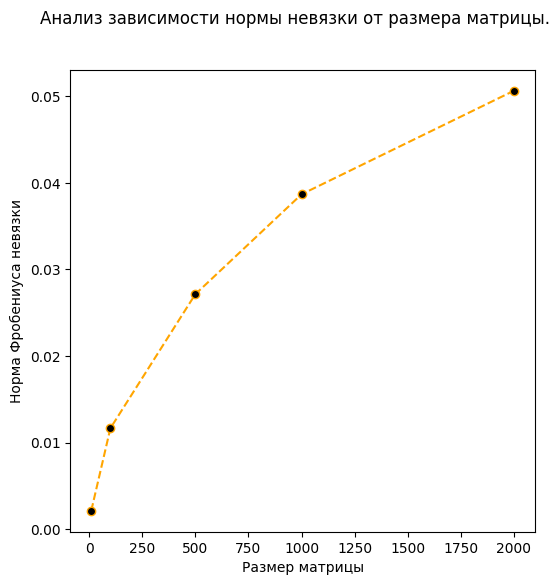

In [ ]:
fig = plt.figure(figsize=(6, 6), dpi=100)
plt.plot(sizes, norms, figure=fig, color='orange', linestyle='--',
         marker='o', markerfacecolor='k');
fig.suptitle("Анализ зависимости нормы невязки от размера матрицы.")
plt.xlabel("Размер матрицы")
plt.ylabel("Норма Фробениуса невязки");

__Вывод__:
1. Метод Холецкого очень стабилен. Даже при вычислении в np.float16 с кратным ростом размера матриц мы не наблюдаем кратного роста ошибки.

Плюсы метода Холецкого по сравнению с LU:
1. Мы не делим на нуль или околонулевые числа при вычислении результата. Это повышает числовую стабильность решения.
2. В методе роста элементов нет!

## №2. Решение системы

Чтобы минимизировать $\|Ax - b\|_2$, нужно перейти к нормальному уравнению $A^TAx = A^Tb$, т.к. $A^TA$ - симм. положит. опред. матрица, то можем решть эту систему методом Холецкого. Ниже представлен код для такого решения:

### Решение системы с использованием разложения Холецкого

In [5]:
def solve_down_traingle(A : NDArray, b : NDArray, using_float16 : bool = False) -> NDArray:
    n = b.shape[0]
    if using_float16:
        y = np.zeros(n, dtype=np.float16)
    else:
        y = np.zeros(n)

    for k in range(n):
        y[k] = (b[k] - y[:k] @ A[k, :k]) / A[k, k]
    return y

In [6]:
def solve_up_traingle(A : NDArray, b : NDArray, using_float16 : bool = False) -> NDArray:
    n = b.shape[0]
    if using_float16:
        y = np.zeros(n, dtype=np.float16)
    else:
        y = np.zeros(n)

    for k in range(n-1, -1, -1):
        y[k] = (b[k] - y[k+1:] @ A[k, k+1:]) / A[k, k]
    return y

In [7]:
def cholesky_solver(A : NDArray, b : NDArray, using_float16 : bool = False) -> NDArray:
    C = cholesky(A, using_float16)
    y = solve_down_traingle(C, b, using_float16)
    x = solve_up_traingle(C.T, y, using_float16)
    return x

In [44]:
A, _ = make_good_matrix(4)
A = np.float16(A)

x = np.random.randint(-10, 10, size=4)
b = A @ x
sol = cholesky_solver(A, b, True)

print("Реальное значение         :", x)
print("Результат метода Холецкого:", sol)
print("Норма разности            :", np.linalg.norm(x - sol, ord=2))

Реальное значение         : [ 0  6 -5 -6]
Результат метода Холецкого: [ 7.381e-04  6.008e+00 -5.004e+00 -5.996e+00]
Норма разности            : 0.009596748971550694


### Итеративное решение

In [49]:
import numpy as np

def iterative_minimize(A, b, x_init, lr=np.float16(0.01), num_epochs=100):
    x = x_init
    for epoch in range(num_epochs):
        residual = A @ x - b
        gradient = A.T.dot(residual)
        x = x - lr * gradient
    return x

# Пример использования
x_init = np.zeros(4)

x_minimized = iterative_minimize(A, b, x_init)
print("Минимизированное решение:", x_minimized)

Минимизированное решение: [-0.05030897  3.98491842 -4.68765894 -6.28329017]


In [60]:
norms_chol

[0.00263, 0.00895, 0.02003, 0.02954]

In [58]:
np.random.seed(42)
sizes = [10, 100, 500, 1000]
norms_chol = []
norms_iterative = []

for size in sizes:
    with np.errstate(under='ignore'):
        A, _ = make_good_matrix(size)
        A = np.float16(A)
        x_init = np.zeros(size, dtype=np.float16)
        x = np.ones(size, dtype=np.float16)
        b = A @ x

        sol_chol = cholesky_solver(A, b, True)
        sol_iterative = iterative_minimize(A, b, x_init)

        norms_chol.append(np.linalg.norm(sol_chol-x))
        norms_iterative.append(np.linalg.norm(sol_iterative-x))

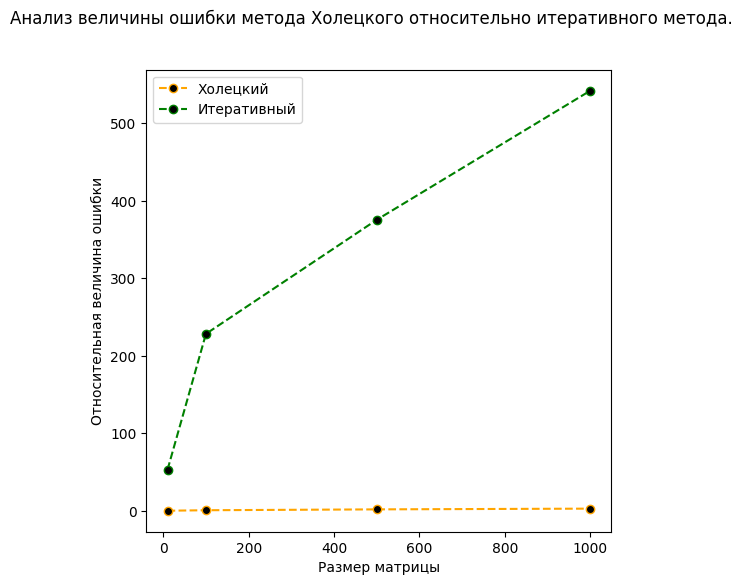

In [62]:
fig = plt.figure(figsize=(6, 6), dpi=100)
plt.plot(sizes, np.array(norms_chol) * 100, figure=fig, color='orange', linestyle='--',
         marker='o', markerfacecolor='k', label='Холецкий');
plt.plot(sizes, np.array(norms_iterative) * 100, figure=fig, color='green', linestyle='--',
         marker='o', markerfacecolor='k', label='Итеративный');
plt.legend()
fig.suptitle(r"Анализ величины ошибки метода Холецкого относительно итеративного метода.")
plt.xlabel("Размер матрицы")
plt.ylabel("Относительная величина ошибки");

Таким образом, получаем, что метод Холецкого гораздо лучше решает данную задачу, чем итеративный. Хотя, конечно, он требует больше ресурсов.